In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import time


In [9]:
batch_size = 100

transform = transforms.Compose((
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,))
))

train_dataset = torchvision.datasets.MNIST(root='../_data',
                                           train=True,
                                           transform=transform,
                                           download=True)

train_loader = data.DataLoader(dataset=train_dataset,
                               batch_size=batch_size,
                               shuffle=True)

In [42]:
# network parameters
z_dim = 32
kernel_size = [3, 3, 4, 4]
channels = [256, 128, 64, 1]
stride = [2, 2, 2, 2]
padding = [0, 0, 1, 1]
lr = 2e-4
betas = (0.5, 0.999)

from gan.dcgan import dcgan

generator, discriminator = dcgan(kernel_size, z_dim, channels, stride, padding)

loss_func = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr, betas)
d_optimizer = optim.Adam(discriminator.parameters(), lr, betas)

real_labels = torch.ones(size=(batch_size, 1)).cuda()
fake_labels = torch.zeros(size=(batch_size, 1)).cuda()

def get_noise(size):
    return torch.randn(size=(size, z_dim, 1, 1)).cuda()


In [12]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

def print_generated():
    gen_images = generator(get_noise(10)).cpu().detach().numpy()
    images = mnist_training_data[0][0][0:10].cpu().numpy()
    for i in range(10):
        plt.subplot(4, 5, i + 1)
        plt.imshow(gen_images[i][0])
        plt.yticks([])
        plt.xticks([])
        plt.subplot(4, 5, i + 11)
        plt.imshow(images[i][0])
        plt.yticks([])
        plt.xticks([])
             

In [13]:
# preload data set
mnist_training_data = {}
def preload():
    print('Loading data')
    for i, (images, labels) in enumerate(train_loader):
        mnist_training_data[i] = (images.cuda(), labels)
    print('Load data ok')   

preload()

Loading data
Load data ok


epoch: 1, iterations: 600, time: 37.93 sec
epoch: 2, iterations: 600, time: 74.86 sec
epoch: 3, iterations: 600, time: 111.87 sec
epoch: 4, iterations: 600, time: 149.00 sec
epoch: 5, iterations: 600, time: 185.75 sec
epoch: 6, iterations: 600, time: 223.21 sec
epoch: 7, iterations: 600, time: 260.52 sec
epoch: 8, iterations: 600, time: 297.58 sec
epoch: 9, iterations: 600, time: 335.24 sec
epoch: 10, iterations: 600, time: 372.42 sec
epoch: 11, iterations: 600, time: 409.73 sec
epoch: 12, iterations: 600, time: 446.90 sec
epoch: 13, iterations: 600, time: 484.17 sec
epoch: 14, iterations: 600, time: 521.87 sec
epoch: 15, iterations: 600, time: 559.39 sec
epoch: 16, iterations: 600, time: 596.70 sec
epoch: 17, iterations: 600, time: 633.75 sec
epoch: 18, iterations: 600, time: 671.03 sec
epoch: 19, iterations: 600, time: 708.27 sec
epoch: 20, iterations: 600, time: 745.51 sec
epoch: 21, iterations: 600, time: 782.76 sec
epoch: 22, iterations: 600, time: 820.18 sec
epoch: 23, iterations

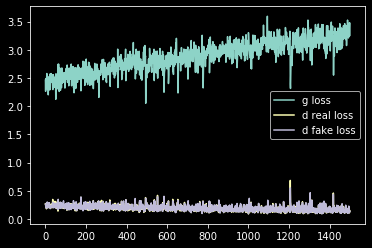

In [52]:
def train(epochs):
    time_start = time.time()
    plot_sep = 20
    iteration_cnt = 0
    g_loss_record = []
    d_real_loss_record = []
    d_fake_loss_record = []
    g_loss_cumsum = 0
    d_real_loss_cumsum = 0
    d_fake_loss_cumsum = 0
    for e in range(epochs):
        for i, (images, _) in mnist_training_data.items():
            
            # train generator
            g_optimizer.zero_grad()
            generated_images = generator(get_noise(batch_size))
            d_fake_discrimination = discriminator(generated_images).view(-1, 1)
            g_loss = loss_func(d_fake_discrimination, real_labels)
            g_loss.backward()
            g_optimizer.step()
    
            # train discriminator
            d_optimizer.zero_grad()
            d_real_discrimination = discriminator(images).view(-1, 1)
            d_fake_discrimination = discriminator(generated_images.detach()).view(-1, 1)
            d_real_loss = loss_func(d_real_discrimination, real_labels)
            d_fake_loss = loss_func(d_fake_discrimination, fake_labels)
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            
            time_train = time.time() - time_start
            print(f'\repoch: {e+1}, iterations: {i+1}, time: {time_train:.2f} sec', end='')
            
            iteration_cnt += 1
            g_loss_cumsum += g_loss
            d_real_loss_cumsum += d_real_loss
            d_fake_loss_cumsum += d_fake_loss
            if iteration_cnt == plot_sep:
                g_loss_record.append(g_loss_cumsum / plot_sep)
                d_real_loss_record.append(d_real_loss_cumsum / plot_sep)
                d_fake_loss_record.append(d_fake_loss_cumsum / plot_sep)
                g_loss_cumsum = 0
                d_real_loss_cumsum = 0
                d_fake_loss_cumsum = 0
                iteration_cnt = 0
        print('')
    plt.plot(g_loss_record)
    plt.plot(d_real_loss_record)
    plt.plot(d_fake_loss_record)
    plt.legend(('g loss', 'd real loss', 'd fake loss'))

train(epochs=50)


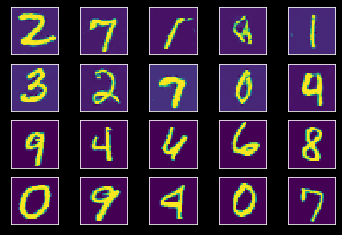

In [53]:
print_generated() 
    
    